# SPICED Academy // WEEK 03 // Bike Sharing Demand Prediction

---

# 0. Set Up

In [1095]:
""" basics """
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime as dt
import numpy as np

""" plotting """
import seaborn as sns
import matplotlib as plt
sns.set(rc={'figure.figsize':(12,10)})
sns.set_color_codes('pastel')

""" feature engineering """
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

""" modelling """
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

""" feature importance """
from sklearn.inspection import permutation_importance

""" cross validation """
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, StratifiedKFold

""" hyperparameter optimization """
from sklearn.model_selection import GridSearchCV

""" performance score """
from sklearn.metrics import mean_squared_log_error

In [1096]:
""" Swtich between execute and skip specific heavy calculations or visually polluting outputs. """
plot = True
cross_val = False
feat_imp = False
hyp_opt = False

---

# 1. Define Business Goal

Predict bike sharing demand in Washington D.C. using past data, applying time-agnostic regression (no auto-vector correlation). 

---

# 2. Get Data

In [1097]:
df = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
X_kaggle = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)

---

# 3. Train-Test Split

In [1098]:
""" Casual, registered and count are labels. Because count is equivalent to the sum of the other two, only count is kept. """
X = df.drop(['casual','registered','count'], axis=1)
y = df['count']

In [1099]:
"""
Dataset has 10,886 observations, of which 20% is dedicated toward testing.
As defined under business goal, section 1, only time-agnostic models will be fitted, thus train-test split is random.  
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

---

# 4. Data Exploration

## 4.1 Checking for NaN Values

In [1100]:
""" There are no missing values. """
X_train.isna().sum().sum(), y_train.isna().sum().sum()

(0, 0)

## 4.2 Date Range

In [1101]:
""" Dates range from January 1st, 2011 until December 19th, 2012. """
df.index.min(), df.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

## 4.3 Plotting

### Label:

* `count`         - number of total rentals

In [1102]:
df_plot = X_train.join(y_train)
df_plot = df_plot.reset_index()

In [1103]:
""" Year, month, week and hour are extracted from datetime and added. """

df_plot['year'] = df_plot['datetime'].dt.year
df_plot['hour'] = df_plot['datetime'].dt.hour
df_plot['month'] = df_plot['datetime'].dt.month
df_plot['weekday'] = df_plot['datetime'].dt.weekday # monday = 0

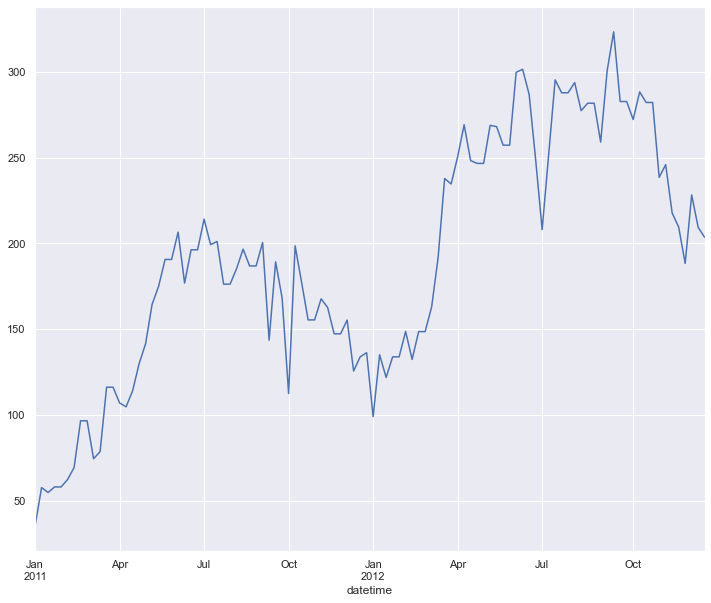

In [1104]:
""" Plot of # of bike rentals per week. """

if plot:
    df_plot.set_index('datetime')['count'].resample('w').mean().fillna(method='ffill').plot()
    despine = True

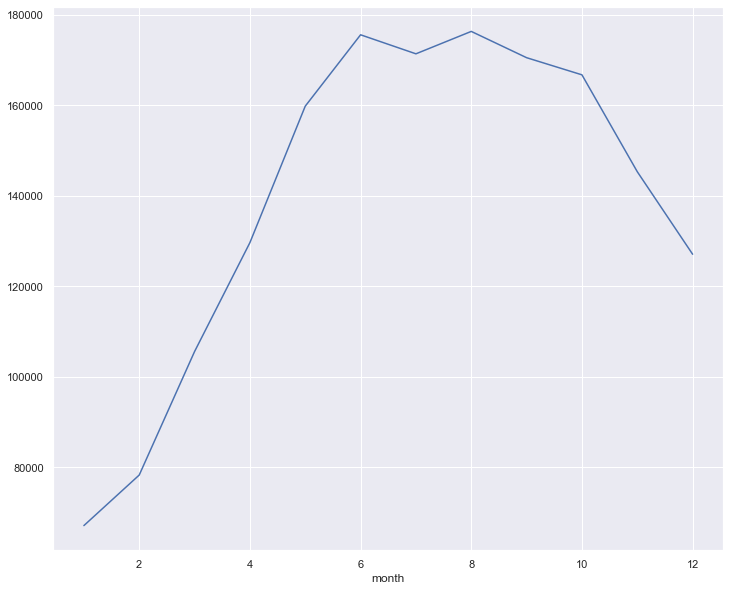

In [1105]:
""" Plot of # of bike rentals accross months. """

if plot:
    df_plot.groupby('month')['count'].sum().plot()
    despine = True

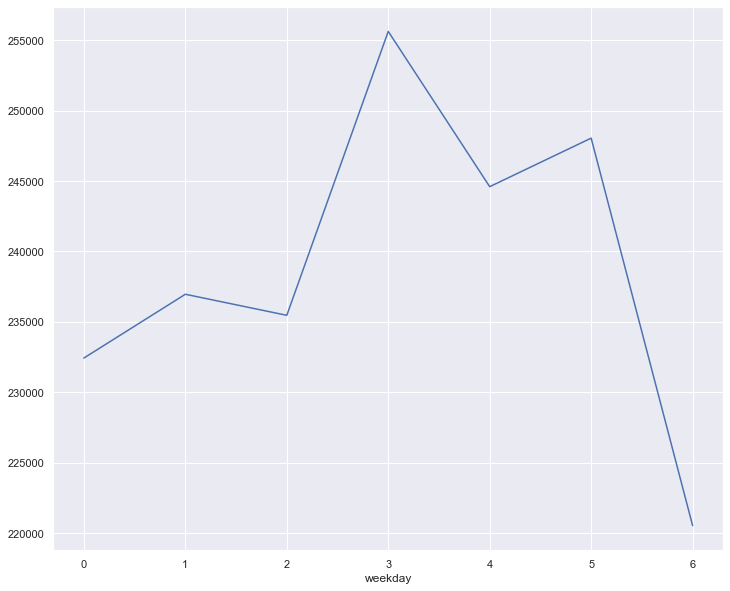

In [1106]:
""" Plot of # of bike rentals accross weekdays. """

if plot:
    df_plot.groupby('weekday')['count'].sum().plot()
    despine = True

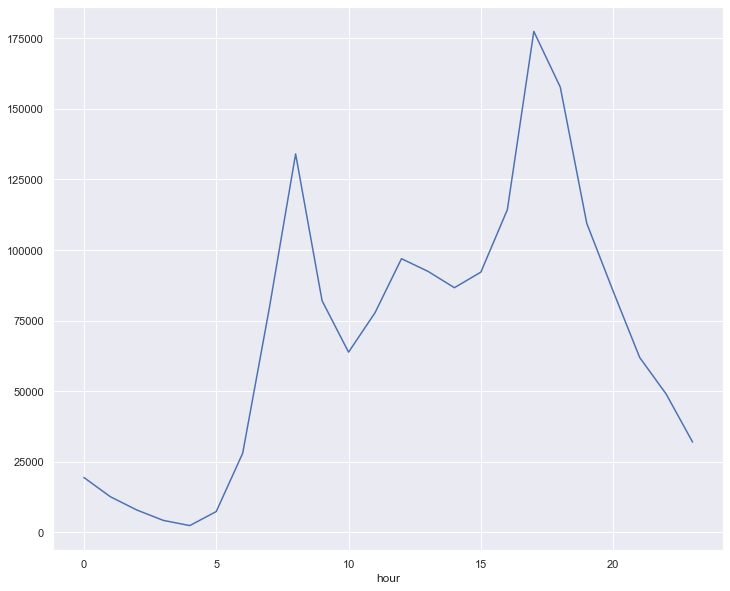

In [1107]:
""" Plot of # of bike rentals accross hours. """

if plot:
    df_plot.groupby('hour')['count'].sum().plot()
    despine = True

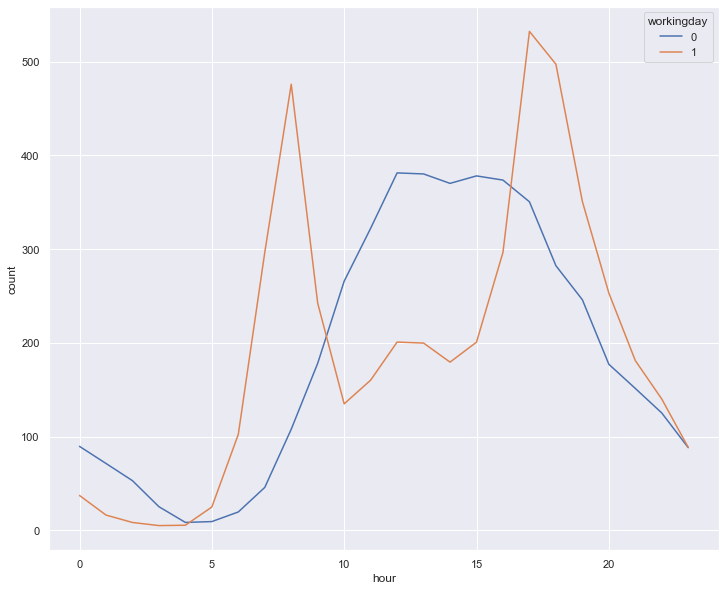

In [1108]:
""" Bike rental behaviour by hour differes in workingday vs weekend. """
count_workingday = df_plot.groupby(['hour', 'workingday'])['count'].mean().reset_index()

if plot:
    sns.lineplot(x='hour', y='count', data=count_workingday, hue='workingday')

In [1109]:
""" Rush hours are defined with hours at top quintile of count accross hours. """
count_threshold = df_plot[df_plot['workingday']==1].groupby('hour')['count'].mean().quantile(0.8)
rushhour_map = df_plot[df_plot['workingday']==1].groupby('hour')['count'].mean() > count_threshold
rushhour_map = rushhour_map * 1 # converting from boolean to binary 
rushhour_map = rushhour_map.to_dict()

In [1110]:
df_plot['rushhour'] = df_plot['hour'].map(rushhour_map)

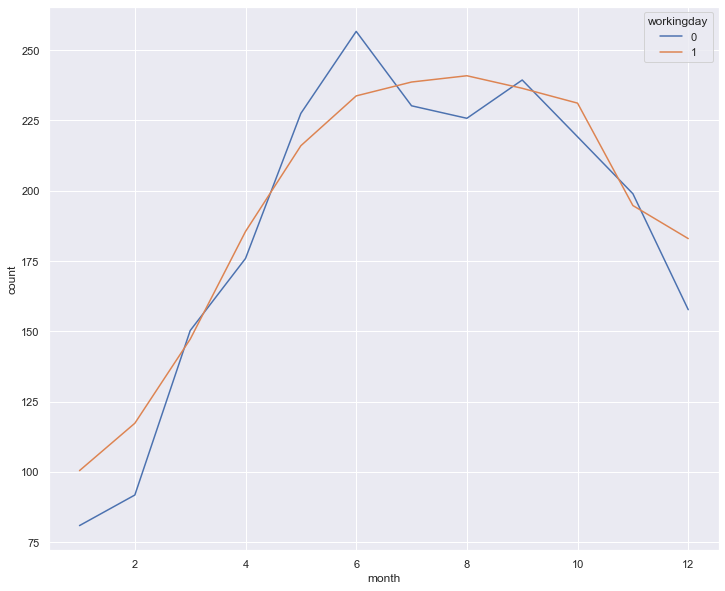

In [1111]:
count_month_workingday = df_plot.groupby(['month', 'workingday'])['count'].mean().reset_index()

if plot:
    sns.lineplot(x='month', y='count', data=count_month_workingday, hue='workingday')

In [1112]:
peakmonth_map = {
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:4,
    7:4,
    8:4,
    9:4,
    10:3,
    11:3,
    12:2
}

In [1113]:
df_plot['peakmonth'] = df_plot['month'].map(peakmonth_map)

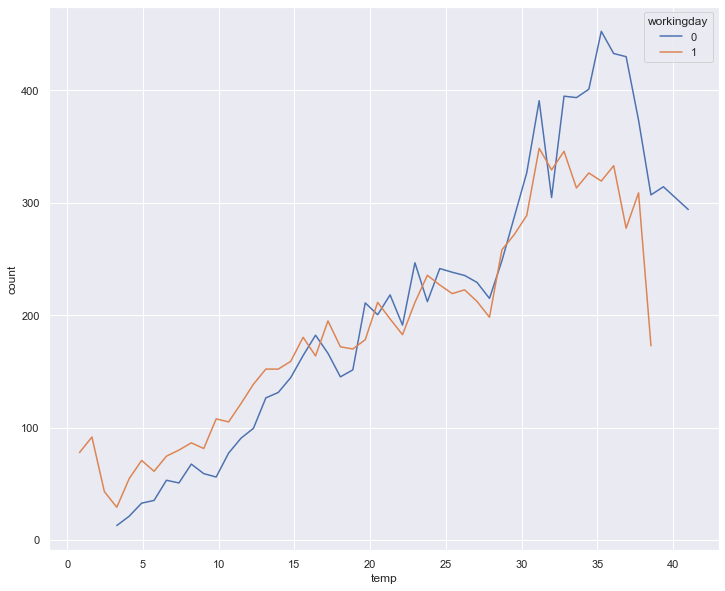

In [1114]:
count_month_workingday = df_plot.groupby(['temp', 'workingday'])['count'].mean().reset_index()

if plot:
    sns.lineplot(x='temp', y='count', data=count_month_workingday, hue='workingday')

### Features:

#### Datetime

* datetime      - hourly date + timestamp  

#### Ordinal

* season        
    * 1 = spring
    * 2 = summer
    * 3 = fall
    * 4 = winter

* weather       
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light * Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

#### Binary

* holiday       - whether the day is considered a holiday
* workingday    - whether the day is neither a weekend nor holiday

#### Continous

* temp          - temperature in Celsius
* atemp         - "feels like" temperature in Celsius
* humidity      - relative humidity
* windspeed     - wind speed

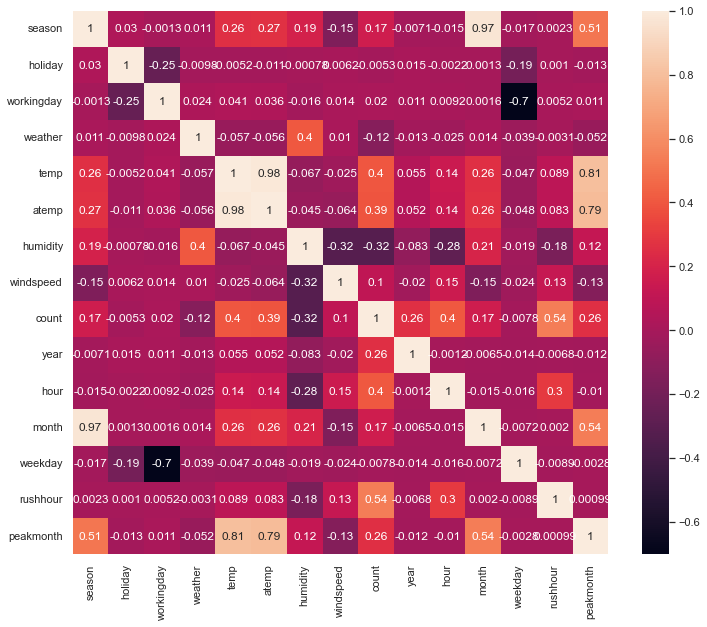

In [1115]:
if plot:
    corr_matrix = df_plot.corr()
    sns.heatmap(corr_matrix, annot=True)

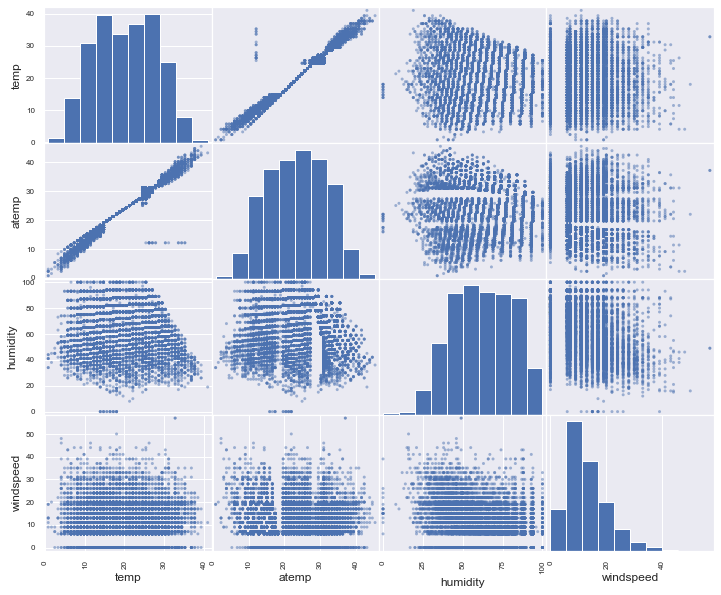

In [1116]:
"""
Plot matrix for continuous variables.
Temp and atemp are clearly correlated. A will be dropped under feature engineering, section 5, as it has a lower correlation with y than temp.
"""

if plot:
    pd.plotting.scatter_matrix(X_train[['temp','atemp','humidity','windspeed']])
    despine = True

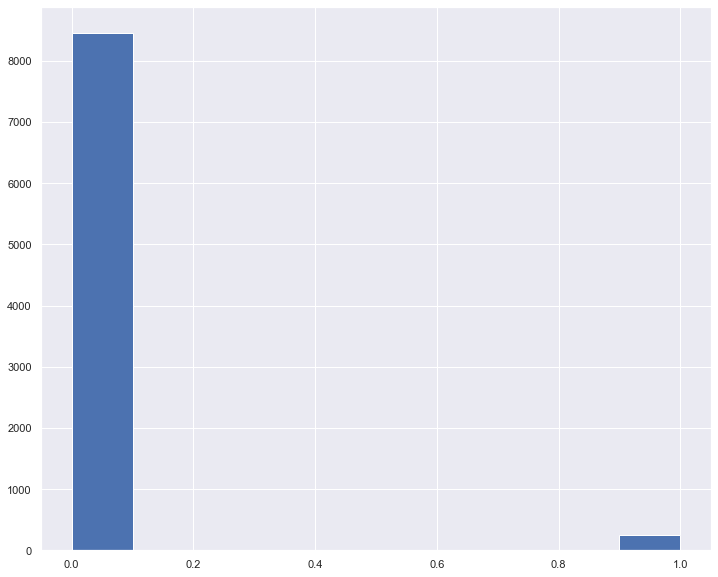

In [1117]:
""" Balance check of feature "holiday": highly imbalanced. """

if plot:
    X_train['holiday'].hist()
    despine = True

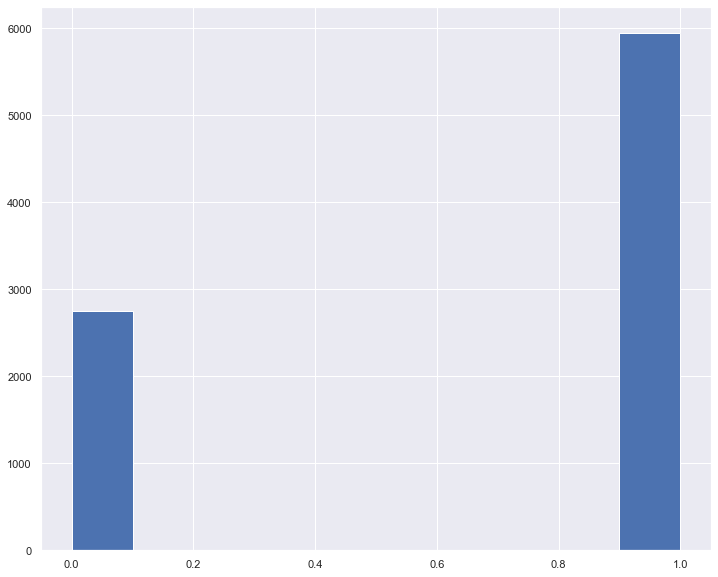

In [1118]:
""" Balance check of feature "workingday": moderately balanced. """

if plot:
    X_train['workingday'].hist()
    despine = True

In [1119]:
""" 
Extreme weather (=4) appears in test but not train dataset. 
This will cause problems in modelling, therefore the value of 4 will be removed at get data section. 
"""

print(X_train.groupby('weather')['weather'].count())
print(X_test.groupby('weather')['weather'].count())

weather
1    5759
2    2270
3     679
Name: weather, dtype: int64
weather
1    1433
2     564
3     180
4       1
Name: weather, dtype: int64


---

# 5. Feature Engineering

In [1120]:
"""
Temp-count correlation vs ATemp-count corr. All three are continuous variables, therefore Pearson correlation is chosen.
Conclusion: drop atemp.
"""
df_plot.set_index('datetime')[['count', 'temp', 'atemp']].corr(method='pearson')['count']


count    1.000000
temp     0.395001
atemp    0.390610
Name: count, dtype: float64

In [1121]:
""" Year, month, week and hour are extracted from datetime and added. """
def feature_engineering(x):
    
    x = x.reset_index()
    
    x['year'] = x['datetime'].dt.year
    x['hour'] = x['datetime'].dt.hour
    x['month'] = x['datetime'].dt.month
    x['weekday'] = x['datetime'].dt.weekday # monday = 0
    
    x['rushhour'] = x['hour'].map(rushhour_map)

    x['peakmonth'] = x['month'].map(peakmonth_map)

    x['weather'][x['weather']==4] = 3 # weather vale of 4 does not appear in train dataset, therefore it is imputed with 3

    return x

In [1122]:
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_kaggle_fe = feature_engineering(X_kaggle)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [1123]:
continuous_columns = ['temp', 'humidity', 'windspeed']
categorical_columns = ['weather', 'peakmonth']
binary_columns = ['workingday', 'rushhour']
date_columns = ['hour', 'weekday']

In [1124]:
column_transformer = ColumnTransformer(
    transformers=[
        #('continuous_normalized', MinMaxScaler((0,1)), continuous_columns), # I am not able to extract feature names from minmax scalar columns
        ('categorical_oce', OneHotEncoder(drop='first', handle_unknown = 'error'), categorical_columns),
        ('binary_passthrough', 'passthrough', binary_columns),
        ('date_passthrough', 'passthrough', date_columns)  ],
    remainder='drop'    )

In [1125]:
column_transformer.fit(X_train_fe)

ColumnTransformer(transformers=[('categorical_oce', OneHotEncoder(drop='first'),
                                 ['weather', 'peakmonth']),
                                ('binary_passthrough', 'passthrough',
                                 ['workingday', 'rushhour']),
                                ('date_passthrough', 'passthrough',
                                 ['hour', 'weekday'])])

In [1126]:
X_train_fe = column_transformer.transform(X_train_fe)
X_test_fe = column_transformer.transform(X_test_fe)
X_kaggle_fe = column_transformer.transform(X_kaggle_fe)

In [1127]:
y_train_fe = np.log1p(y_train)
y_test_fe = np.log1p(y_test) # this appears to be unecessary, perhaps delete this?

---

# 6. Train Model

## 6.1 Model 1: Linear Regression

In [1128]:
m1 = LinearRegression()
m1.fit(X_train_fe, y_train_fe)

LinearRegression()

In [1129]:
""" Coefficients are too extreme, with e+11. """
print(m1.coef_, m1.intercept_)

[ 0.0396694  -0.6161327   0.50234471  0.81897234  0.94764271  0.05134625
  0.95563623  0.10175234  0.02802333] 2.4925962779346404


In [1130]:
print(m1.score(X_train_fe, y_train_fe)) # R2

0.46355648845704023


## 6.2 Model 2: RandomForest Regression

In [1131]:
""" Hyperparameters defined through GridSearchCV optimization in section 7.3 """
m2 = RandomForestRegressor(n_estimators=100, max_depth=40, min_samples_leaf=10)
m2.fit(X_train_fe, y_train_fe)

RandomForestRegressor(max_depth=40, min_samples_leaf=10)

In [1132]:
print(m2.score(X_train_fe, y_train_fe)) # R2

0.9103243365953476


## 6.3 Model 3: Ridge Regression

In [1133]:
""" As the Linear Regression produced extreme coefficient values, I use a Ridge regression to penalize large coefficient. """  
m3 = Ridge(alpha=10)
m3.fit(X_train_fe, y_train_fe)

Ridge(alpha=10)

In [1134]:
""" Compared to Linear Regression the coefficient levels are more reasonable. There is no gain in R2, however. """
print(m3.coef_, m3.intercept_)

[ 0.0402171  -0.60623192  0.48472819  0.79990548  0.92925532  0.05111711
  0.94828347  0.10185912  0.0279625 ] 2.507659162394484


In [1135]:
print(m3.score(X_train_fe, y_train_fe)) # R2

0.46352583915061196


---

# 7. Hyperparameter Optimization // Cross Validation

## 7.1 Cross-Validation

In [1136]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)

In [1137]:
cross_accuracy_log_m1 = cross_val_score(
    m1,   # estimator: # the model you want to evaluate
    X=X_train_fe,         # the training input data
    y=y_train_fe,         # the training output data
    cv=kf  )   # evaluation metric

In [1138]:
cross_accuracy_log_m1

array([0.46775198, 0.44386772, 0.46598707, 0.46449892, 0.45105296,
       0.47320483, 0.48869749, 0.47639563, 0.43605914, 0.44766154])

In [1139]:
f"Cross-validation mean {100 * cross_accuracy_log_m1.mean():5.3f} +- {100 * cross_accuracy_log_m1.std():5.3f}"

'Cross-validation mean 46.152 +- 1.557'

In [1140]:
if cross_val:

    cross_accuracy_log_m2 = cross_val_score(
        m2,   # estimator: # the model you want to evaluate
        X=X_train_fe,         # the training input data
        y=y_train_fe,         # the training output data
        cv=kf  )   # evaluation metric
    
    f"Cross-validation mean {100 * cross_accuracy_log_m2.mean():5.3f} +- {100 * cross_accuracy_log_m2.std():5.3f}"

## 7.2 Feature Importance

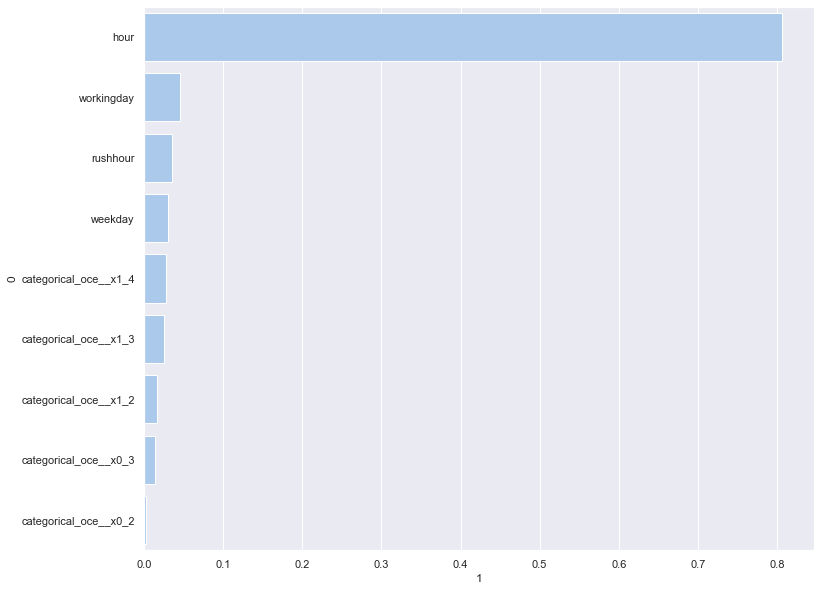

In [1141]:
""" Drop holiday, and season, as they have low feature importance. """
if plot:

    feature_names = np.array(column_transformer.get_feature_names())
    feature_importances = m2.feature_importances_  

    feature_importance = pd.DataFrame([
        feature_names, 
        feature_importances
        ]).T.sort_values(1, ascending=False)

    feature_importance

    sns.set_color_codes('pastel')
    sns.barplot(x=1, y=0, data=feature_importance, label='Total', color='b')

    despine=True

In [1142]:
if feat_imp:
    r = permutation_importance(m2, X_train_fe, y_train_fe, n_repeats=30, random_state=101)

In [1143]:
if feat_imp:

    feature_names = column_transformer.get_feature_names()

    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{feature_names[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")

## 7.3 Hyperparameter Optimization

In [1144]:
param_grid = {
    'max_depth': [2,10,40,100],
    'n_estimators': [2,10,40,100],
    'min_samples_leaf': [2,10]  }

In [1145]:
g = GridSearchCV(
    m2, 
    param_grid, 
    cv=5,
    return_train_score=True  )

In [1146]:
if hyp_opt:
    g.fit(X_train_fe, y_train_fe)

In [1147]:
if hyp_opt:
    results = pd.DataFrame(g.cv_results_)

In [1148]:
if hyp_opt:
    col_names = ['mean_test_score', 'mean_train_score', 'mean_fit_time',
                'param_max_depth', 'param_n_estimators', 'param_min_samples_leaf',]
                #'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']

    sorted_df = results.sort_values('mean_train_score', ascending=False)[col_names]
    sorted_df['mtest_minus_mtrain_score'] = sorted_df['mean_train_score'] - sorted_df['mean_test_score'] 


In [1149]:
sorted_df

,mean_test_score,mean_train_score,mean_fit_time,param_max_depth,param_n_estimators,param_min_samples_leaf,mtest_minus_mtrain_score
19,0.890799,0.930015,0.690880,40,100,2,0.039216
27,0.890948,0.929970,0.702123,100,100,2,0.039021
26,0.890648,0.929673,0.407382,100,40,2,0.039025
18,0.890287,0.929647,0.241598,40,40,2,0.039360
25,0.888005,0.927983,0.068172,100,10,2,0.039977
17,0.888165,0.927956,0.061150,40,10,2,0.039791
24,0.878371,0.919784,0.014485,100,2,2,0.041414
16,0.877207,0.919717,0.013328,40,2,2,0.042510
11,0.893790,0.918660,0.504370,10,100,2,0.024870
10,0.893401,0.918175,0.203053,10,40,2,0.024774


In [1150]:
""" When considering mean_train_score and mean_test_score, the ideal random forest model should have 40 depth, 100 estimators and 10 leaf. """

train_test_diff_threshold = 0.02
sorted_df[sorted_df['mtest_minus_mtrain_score'] < train_test_diff_threshold]

,mean_test_score,mean_train_score,mean_fit_time,param_max_depth,param_n_estimators,param_min_samples_leaf,mtest_minus_mtrain_score
31,0.892892,0.908320,0.961191,100,100,10,0.015428
22,0.892898,0.908295,0.301339,40,40,10,0.015397
23,0.892840,0.908191,0.646887,40,100,10,0.015352
30,0.892571,0.907889,0.429920,100,40,10,0.015317
21,0.891192,0.907022,0.080380,40,10,10,0.015830
29,0.891138,0.906616,0.061297,100,10,10,0.015478
15,0.889391,0.903394,0.466967,10,100,10,0.014003
14,0.888284,0.902817,0.188469,10,40,10,0.014533
13,0.889030,0.902225,0.048051,10,10,10,0.013196
20,0.884168,0.901097,0.016595,40,2,10,0.016929


---

# 8. Calculate Test Score

## Model 1: Test Score

In [1151]:
y_train_pred_m1 = m1.predict(X_train_fe)
y_train_pred_m1 = np.exp(y_train_pred_m1) - 1

RMSLE_score_train_m1 = np.sqrt(mean_squared_log_error(y_train, y_train_pred_m1))

print('RMSLE score on train dataset:',RMSLE_score_train_m1)

RMSLE score on train dataset: 1.0401965434181615


In [1152]:
y_test_pred_m1 = m1.predict(X_test_fe)
y_test_pred_m1 = np.exp(y_test_pred_m1) - 1
y_test_pred_m1[y_test_pred_m1 < 0] = 0.0

RMSLE_score_test_m1 = np.sqrt(mean_squared_log_error(y_test, y_test_pred_m1))

print('RMSLE score on test dataset:', RMSLE_score_test_m1)

RMSLE score on test dataset: 1.036897603994621


## 8.2 Model 2: Test Score

In [1153]:
y_train_pred_m2 = np.exp(m2.predict(X_train_fe)) - 1

RMSLE_score_train_m2 = np.sqrt(mean_squared_log_error(y_train, y_train_pred_m2))

print('RMSLE score on train dataset:',RMSLE_score_train_m2)

RMSLE score on train dataset: 0.42529542115713836


In [1154]:
y_test_pred_m2 = m2.predict(X_test_fe)
y_test_pred_m2 = np.exp(y_test_pred_m2) - 1

RMSLE_score_test_m2 = np.sqrt(mean_squared_log_error(y_test, y_test_pred_m2))

print('RMSLE score on test dataset:',RMSLE_score_test_m2)

RMSLE score on test dataset: 0.4791808837794505


## Predict for Kaggle

In [1155]:
y_kaggle = np.exp(m2.predict(X_kaggle_fe)) - 1
y_kaggle = pd.DataFrame(y_kaggle, columns=['count'])
y_kaggle = round(y_kaggle, 0)

datetime_column = pd.DataFrame(X_kaggle.reset_index()['datetime'])

y_kaggle = datetime_column.join(y_kaggle).set_index('datetime')

#y_kaggle.to_csv('y_kaggle.csv')

---

# 9. Deploy & Monitor

In [1156]:
!jupyter nbconvert --to html code-bike-dmnd-pred.ipynb

[NbConvertApp] Converting notebook code-bike-dmnd-pred.ipynb to html
[NbConvertApp] Writing 1524394 bytes to code-bike-dmnd-pred.html


---

# 10. Kaggle Submission Score
RMSLE: **0.54062** (RandomForest)

---

# 11. Further Improvements

* For a given hour of the day, how does temperature affect count.